In [5]:
import pandas as pd

# Step 1: Load both CSV files
ev_data = pd.read_csv("synthetic_ev_occupancy.csv", parse_dates=["timestamp"])
weather_data = pd.read_csv("synthetic_weather.csv", parse_dates=["timestamp"])

# Step 2: Merge them on 'timestamp'
data = pd.merge(ev_data, weather_data, on="timestamp")

# Step 3: Add helpful time features
data["hour"] = data["timestamp"].dt.hour
data["day_of_week"] = data["timestamp"].dt.dayofweek
data["is_weekend"] = data["day_of_week"].isin([5, 6])

# Step 4: Show first 5 rows
data.head()

,timestamp,Station_1,Station_2,Station_3,Station_4,Station_5,total_busy_chargers,temperature,humidity,precipitation,wind_speed,hour,day_of_week,is_weekend
0,2023-01-01 00:00:00,2.244996,1.164082,0.000000,3.342218,0.633061,7.384357,27.483571,53.433868,0.0,10.479569,0,6,True
1,2023-01-01 01:00:00,1.809051,2.547389,1.572267,1.658407,0.502390,8.089505,24.308678,67.081711,0.5,6.916975,1,6,True
2,2023-01-01 02:00:00,6.136830,7.747480,3.809014,4.878635,8.267997,30.839957,28.238443,71.673911,0.0,13.797124,2,6,True
3,2023-01-01 03:00:00,2.788869,5.679378,5.235222,5.637495,8.874564,28.215529,32.615149,52.894384,0.0,7.401475,3,6,True
4,2023-01-01 04:00:00,13.384597,9.679606,6.436656,12.645905,10.517348,52.664111,23.829233,46.967804,0.0,12.908372,4,6,True


In [7]:
!pip install prophet

In [8]:
from prophet import Prophet

# Prophet expects column names: 'ds' (datetime), 'y' (value to predict)
df = data[["timestamp", "total_busy_chargers"]].rename(columns={
    "timestamp": "ds",
    "total_busy_chargers": "y"
})

In [9]:
# Create Prophet model
model = Prophet()

# Train it on your data
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_nyqaih/y461p_f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_nyqaih/1ewusmrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6986', 'data', 'file=/tmp/tmpb_nyqaih/y461p_f0.json', 'init=/tmp/tmpb_nyqaih/1ewusmrd.json', 'output', 'file=/tmp/tmpb_nyqaih/prophet_model69mkr35_/prophet_model-20250614120528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
# Create future timestamps (72 hours = 3 days)
future = model.make_future_dataframe(periods=72, freq='H')

# Predict usage
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


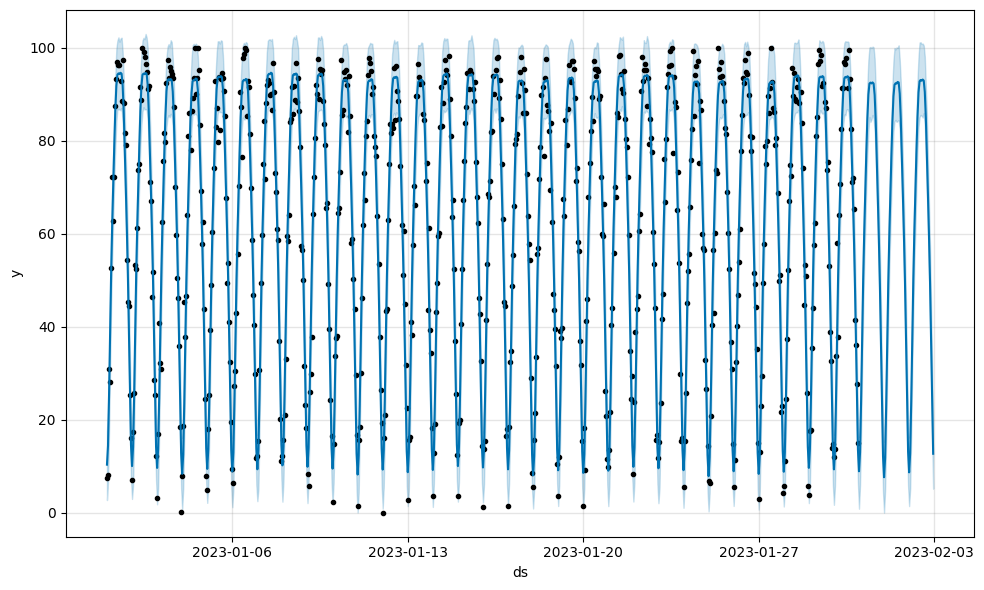

In [11]:
# Plot forecast
model.plot(forecast);

In [12]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv("ev_demand_forecast.csv", index=False)